In [2]:
import uproot, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [435]:
## Read Electron Total Energy Nonlinearity:
Etrue = np.arange(0.01, 8, 0.01);
df = pd.read_table('../../../Simulation/Nonlinearity/electron/Calc_NonL.txt');
electron_NL = df['nonl'].values

In [376]:
electron_NL[0]

0.7620754399999999

In [8]:
## Read Electron Total Resolution
df = pd.read_table("../../../Simulation/Nonlinearity/electron/Cerenkov/totPE_smearing.txt", sep=' ')
electron_totpe = df['totpe'].values
electron_sigma = df['sigma'].values

In [9]:
## choose energy scale: 
A = 1481.06

In [199]:
## read primary e+- info for gamma  ===> binning in 10keV
bincont1 = [[]for i in range(800)]
with open('../../../Reconstruction/energy_model/gamma/log_2MeV') as f:
    for lines in f.readlines():
        line = lines.strip(' \n')
        data = line.split(' ')
        KE = [];
        for i in range(len(data)):
            KE.append(float(data[i]))
        cont, edge = np.histogram(KE, bins=800, range=(0,8))
        for j in range(800):
            bincont1[j].append(cont[j])
bincon1 = np.array(bincont1)

In [337]:
### find the corresponding bin for energy:
def find_bin_Idx(xx, Etrue):
    if(xx<=Etrue[0]):   # in the first bin
        return int(0)
    for i in range(798):
        if(xx > Etrue[i] and xx <= Etrue[i+1] ):
            return int(i+1)
        
# interpolation:
def itpl(idx, array, xx):
    if(idx == 0):
        return array[0] / 0.01 * xx;
    else:
        return (array[idx]-array[idx-1])* (xx-0.01*(idx))/0.01 + array[idx-1]

In [130]:
# for single event
mean_dist = []; sigma_dist =[]; Evis_dist = []; Edep_dist = [];
for i in range(20):
    mean_evt = 0.; sigma_evt = 0.; Evis_evt = 0.; Edep_evt = 0.;
    for j in range(799):
        #mean_evt += electron_totpe[i]*bincon1[j,i]
        Edep_evt += Etrue[j] *bincon1[j,i];
        Evis_evt += Etrue[j] *electron_NL[j] * bincon1[j,i];
        mean_evt += Etrue[j] *electron_NL[j] * bincon1[j,i] * A
        sigma_evt += bincon1[j,i]**2 * electron_sigma[j]**2
    sigma_evt = np.sqrt(sigma_evt)
    mean_dist.append(mean_evt); sigma_dist.append(sigma_evt); Evis_dist.append(Evis_evt); Edep_dist.append(Edep_evt)
    print("Event" + str(i) + " =====> Average: " + str(round(mean_evt, 2))+ " =====> Sigma: " + str(round(sigma_evt, 2)))

0.6828839513932179
0.7801173039059341
0.8235125534825679
0.8490409175150136
0.8661604869890588
0.8785531933455585
0.8880215119728626
0.8955272228983154
0.901644500734409
0.9067399081206454
0.9110590578284372
0.9147732162705229
0.9180056831664359
0.9208476859785196
0.923368497359868
0.9256215565384792
0.9276487794404584
0.9294835983394965
0.9311530385339792
0.9326791707963
0.9349367544096948
0.9367549326443512
0.9384922393193488
0.9402021120780528
0.9418797622508436
0.9434515369788836
0.9451064587300186
0.9466229459704946
0.9480931209486906
0.9495320649360668
0.9508109272709996
0.9522774912491071
0.953639458733378
0.955024813368718
0.9563301050071122
0.9573855499153784
0.9585326469416988
0.9597171458337378
0.9610291567124988
0.9620283404194012
0.9631482748321906
0.9641093159489816
0.9650258905640862
0.9661146358239058
0.9671899121961708
0.9680934713736012
0.9689713616151244
0.9700035029471672
0.9707709518145056
0.9715953601945241
0.9725585578468808
0.9732573739207814
0.9739982908992952


1.025835230585298
1.0260857325954869
1.0261407392833521
1.0259516221211922
1.0261359052158765
1.0260600503138266
1.026235384028864
1.0260651454460084
1.0261619093426315
1.0259197791976566
1.0261909874795407
1.0264941937344558
1.0261991783635178
1.0264846797386986
1.0265913973969332
1.0266890149367356
1.0263486492636795
1.0261828419762078
1.0266959127505235
1.026739928953148
1.0268474416881614
1.026763621494669
1.026687099563472
1.026895576520015
1.0265182201811804
1.0271510581397798
1.0272996618588195
1.0271357338776523
1.027322083997411
1.0273656485790508
1.0269195704081844
1.0271404877046453
1.0271151195338044
1.027405661737932
1.027013809884492
1.0271352206925777
1.026975642256891
1.0274347824959311
1.0272752398289808
1.0274398048228046
1.0277879142046675
1.027787001667655
1.0271245807583744
1.0274665598676072
1.0274656132001112
1.027470394500847
1.0276040159444009
1.027555364077265
1.0276448092287034
1.0277002675754403
1.0276674911228971
1.028072923905616
1.0275701973250515
1.02779

1.02080587922246
1.020430018428907
1.0204660554016405
1.0204825930732957
1.020231535468353
1.0206296459782314
1.021297900960996
1.0212833468515623
1.0211564527564547
1.0215740381812033
1.020915186775735
1.021388713742988
1.02101775513312
1.0213690947443574
1.0212432695688392
1.0221342623540774
1.0213423056695137
1.0219004793392563
1.021469803541227
1.021929545856685
1.0218664394895152
1.0220493623643807
1.0219741678684082
1.0222780914508207
1.0217041327125411
1.0223981591040854
1.0222127170206692
1.0225340367409856
1.022327324425687
1.0225367240452157
1.02249335144882
1.0228639728028777
1.0227877069376032
1.023054705478572
1.0228599692930571
1.0234332421694208
1.0229701856012126
1.0229228612434536
1.0227658445858834
1.0230284684276223
1.0234662628048388
1.0229258422893064
1.0231783219898871
1.0235963114911713
1.0234651042424403
1.0232540025870358
1.023981127939756
1.023419597853502
1.0236665726327467
1.024257319622672
1.023730184304595
1.0236095321858696
1.0241175069128097
1.0237537071

1.0076959523596265
1.0079946987733086
1.0081914728339538
1.0086098896174835
1.0084322633740108
1.0086338392776328
1.0089599661329471
1.0090451557927245
1.0092731521590057
1.0094070213821558
1.0096344399671202
1.0098750588296952
1.0099643118340371
1.0100680067496453
1.0104114485253908
1.010509897679848
1.0108484933527355
1.0107760438024365
1.0112373517131723
1.0112080034521156
1.0113267397715924
1.011718384790787
1.011746801839825
1.0117396808167074
1.0118995279752472
1.0121529082854437
1.0124651999742684
1.0125208059466015
1.0126382449686897
1.0128284900015188
1.0131150807367229
1.0131435084558724
1.0133578193626038
1.0135112873650616
1.0133587007844913
1.0139003283298798
1.0137429766244157
1.0139244539546366
1.0143845726889738
1.014288756388178
1.014438292622076
1.0146564339571842
1.0146993809913107
1.0148317878577402
1.0148045015909517
1.0150322684812734
1.0152333907515252
1.0152305072314844
1.0154659183089
1.015470416201265
1.01570770819801
1.0157105020339294
1.0161406928837693
1.01

0.955024813368718
0.9563301050071122
0.9573855499153784
0.9585326469416988
0.9597171458337378
0.9610291567124988
0.9620283404194012
0.9631482748321906
0.9641093159489816
0.9650258905640862
0.9661146358239058
0.9671899121961708
0.9680934713736012
0.9689713616151244
0.9700035029471672
0.9707709518145056
0.9715953601945241
0.9725585578468808
0.9732573739207814
0.9739982908992952
0.9747865096346938
0.9755029365603478
0.9763879158609088
0.9772643138467728
0.9779425101983032
0.9786133170802084
0.9793838563953338
0.97986403397862
0.9805573420271372
0.9813614152758872
0.9818226644607946
0.9825406771054
0.9831105789425452
0.9837393383564562
0.984236361406036
0.984887298678312
0.98543624206187
0.9859306507045524
0.986440711851139
0.9870777254141154
0.9876389798023174
0.9880455442791716
0.9886415084291462
0.9891723078277632
0.9896535129218522
0.9900948803008068
0.9904273513779208
0.9911980771689141
0.991544789254596
0.992047836997394
0.9921712253310244
0.9927561283480696
0.9933913934224279
0.9937

1.0287775454761754
1.0293385016094754
1.0292139423006623
1.0290311965082102
1.0291696983451126
1.0287394748675909
1.0288249176474784
1.0292687179496094
1.0289256090707006
1.0288396132332944
1.0290612953264
1.0286683140198905
1.0291021212580147
1.0290613249603415
1.0290340036333114
1.0293018304637462
1.0294440626557355
1.0292561404233278
1.0292010876975952
1.0292168220365787
1.0295330091089288
1.029382581779071
1.0291685317851147
1.0294492889128637
1.029460092686113
1.0288453449575004
1.029730117188055
1.029873857450435
1.029514973644138
1.0295453569705617
1.0294231643473934
1.0297696528256546
1.0293792648463542
1.0295118230838567
1.029638576897437
1.0297128643088158
1.029980548786287
1.0302337438482834
1.0296419331543285
1.0298299970370468
1.029645514894154
1.0296484752561603
1.0295281146605928
1.0296732049449435
1.0296453446691856
1.0298127853601908
1.029601256791807
1.0298989044363618
1.029936126470649
1.0293643863879482
1.0298885653226502
1.0298252891554658
1.0298225877656957
1.0299

1.0262370947476247
1.0260397443717797
1.0260430569949637
1.025835230585298
1.0260857325954869
1.0261407392833521
1.0259516221211922
1.0261359052158765
1.0260600503138266
1.026235384028864
1.0260651454460084
1.0261619093426315
1.0259197791976566
1.0261909874795407
1.0264941937344558
1.0261991783635178
1.0264846797386986
1.0265913973969332
1.0266890149367356
1.0263486492636795
1.0261828419762078
1.0266959127505235
1.026739928953148
1.0268474416881614
1.026763621494669
1.026687099563472
1.026895576520015
1.0265182201811804
1.0271510581397798
1.0272996618588195
1.0271357338776523
1.027322083997411
1.0273656485790508
1.0269195704081844
1.0271404877046453
1.0271151195338044
1.027405661737932
1.027013809884492
1.0271352206925777
1.026975642256891
1.0274347824959311
1.0272752398289808
1.0274398048228046
1.0277879142046675
1.027787001667655
1.0271245807583744
1.0274665598676072
1.0274656132001112
1.027470394500847
1.0276040159444009
1.027555364077265
1.0276448092287034
1.0277002675754403
1.0276

1.0202640394578508
1.020442377948637
1.02080587922246
1.020430018428907
1.0204660554016405
1.0204825930732957
1.020231535468353
1.0206296459782314
1.021297900960996
1.0212833468515623
1.0211564527564547
1.0215740381812033
1.020915186775735
1.021388713742988
1.02101775513312
1.0213690947443574
1.0212432695688392
1.0221342623540774
1.0213423056695137
1.0219004793392563
1.021469803541227
1.021929545856685
1.0218664394895152
1.0220493623643807
1.0219741678684082
1.0222780914508207
1.0217041327125411
1.0223981591040854
1.0222127170206692
1.0225340367409856
1.022327324425687
1.0225367240452157
1.02249335144882
1.0228639728028777
1.0227877069376032
1.023054705478572
1.0228599692930571
1.0234332421694208
1.0229701856012126
1.0229228612434536
1.0227658445858834
1.0230284684276223
1.0234662628048388
1.0229258422893064
1.0231783219898871
1.0235963114911713
1.0234651042424403
1.0232540025870358
1.023981127939756
1.023419597853502
1.0236665726327467
1.024257319622672
1.023730184304595
1.02360953218

1.007274653479174
1.0074029424860114
1.0076959523596265
1.0079946987733086
1.0081914728339538
1.0086098896174835
1.0084322633740108
1.0086338392776328
1.0089599661329471
1.0090451557927245
1.0092731521590057
1.0094070213821558
1.0096344399671202
1.0098750588296952
1.0099643118340371
1.0100680067496453
1.0104114485253908
1.010509897679848
1.0108484933527355
1.0107760438024365
1.0112373517131723
1.0112080034521156
1.0113267397715924
1.011718384790787
1.011746801839825
1.0117396808167074
1.0118995279752472
1.0121529082854437
1.0124651999742684
1.0125208059466015
1.0126382449686897
1.0128284900015188
1.0131150807367229
1.0131435084558724
1.0133578193626038
1.0135112873650616
1.0133587007844913
1.0139003283298798
1.0137429766244157
1.0139244539546366
1.0143845726889738
1.014288756388178
1.014438292622076
1.0146564339571842
1.0146993809913107
1.0148317878577402
1.0148045015909517
1.0150322684812734
1.0152333907515252
1.0152305072314844
1.0154659183089
1.015470416201265
1.01570770819801
1.015

1.0308790623781587
1.030604907031866
1.0303755134823107
1.0302086880155936
1.0305365233367012
1.0307709637635865
1.0309263107823428
1.0308737302576696
1.030574553512707
1.0306404724734404
1.0309186884454309
1.0310038259523244
1.030708301343621
1.030867810092147
1.0307549034590648
1.0310915592768153
1.0308950944884083
1.0306701724461595
1.0305727515254413
1.030673584614255
1.0306586109079197
1.031291254782556
1.0305609678833645
1.0307564571751835
1.030595282725252
1.0309647447924188
1.0307260978957569
1.031153065147648
1.0309315835465538
1.0308720085019558
1.031186105266967
1.0308760595078148
1.0310656084810632
1.03106194727317
1.0306794010024565
1.0307327944089135
1.0309772781637478
1.0313113704815968
1.0314099136023
1.0308555725794657
1.0311097993765854
1.031126172790652
1.0308859930889451
1.0312474617261758
1.030956780006128
1.030827763418514
1.0313559589111356
1.0308589362258804
1.0311881084337498
1.0307314604197988
1.030975696654946
1.0310621231760195
1.0314313973695413
1.030997347

1.0309263107823428
1.0308737302576696
1.030574553512707
1.0306404724734404
1.0309186884454309
1.0310038259523244
1.030708301343621
1.030867810092147
1.0307549034590648
1.0310915592768153
1.0308950944884083
1.0306701724461595
1.0305727515254413
1.030673584614255
1.0306586109079197
1.031291254782556
1.0305609678833645
1.0307564571751835
1.030595282725252
1.0309647447924188
1.0307260978957569
1.031153065147648
1.0309315835465538
1.0308720085019558
1.031186105266967
1.0308760595078148
1.0310656084810632
1.03106194727317
1.0306794010024565
1.0307327944089135
1.0309772781637478
1.0313113704815968
1.0314099136023
1.0308555725794657
1.0311097993765854
1.031126172790652
1.0308859930889451
1.0312474617261758
1.030956780006128
1.030827763418514
1.0313559589111356
1.0308589362258804
1.0311881084337498
1.0307314604197988
1.030975696654946
1.0310621231760195
1.0314313973695413
1.0309973471315104
1.031045795510081
1.0312498630018287
1.0312047604146801
1.030963433707464
1.031468389768712
1.03134868193

In [132]:
np.array(Evis_dist) / np.array(Edep_dist)

array([0.91618735, 0.9441501 , 0.91447503, 0.93835824, 0.90943252,
       0.89592013, 0.92557211, 0.89792119, 0.92371325, 0.90713159,
       0.90103288, 0.91203845, 0.91392779, 0.89616165, 0.90509722,
       0.89225935, 0.92521081, 0.87092156, 0.92417939, 0.92545713])

In [52]:
def gauss_dist(x, mean, sigma):
    return np.exp(-(x-mean)**2/2/sigma**2)

Text(0.5, 0, 'totalPE')

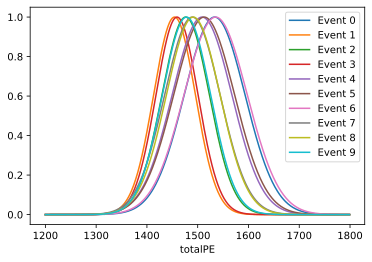

In [66]:
xx = np.arange(1200,1800,1)
for j in range(10):
    for i in range(len(xx)):
        yy = gauss_dist(xx, mean_dist[j], sigma_dist[j])
    plt.plot(xx, yy, '-', label='Event %d' %j)
plt.legend()
plt.xlabel("totalPE")

In [201]:
gamma_totpe = 0.; gamma_sigma = 0.; gamma_Evis = 0.; count = 0;

In [202]:
## Predict with 1000 events with binning data
mean_dist = []; sigma_dist =[];
iterator = 10000;
for i in range(iterator):
    mean_evt = 0.; sigma_evt = 0.; Evis_evt = 0.
    for j in range(799):
        count += bincon1[j,i]
        #mean_evt += electron_totpe[i]*bincon1[j,i]
        
        Evis_evt += Etrue[j] *electron_NL[j] * bincon1[j,i]
        mean_evt += Etrue[j] *electron_NL[j] * bincon1[j,i] * A
        sigma_evt += bincon1[j,i]**2 * electron_sigma[j]**2
        
        gamma_Evis += Etrue[j] *electron_NL[j] * bincon1[j,i]
        gamma_totpe += Etrue[j] *electron_NL[j] * bincon1[j,i]*A
        gamma_sigma += bincon1[j,i]/100 * electron_sigma[j]**2
     
        
    sigma_evt = np.sqrt(sigma_evt)
    gamma_totpe /= iterator; gamma_Evis /= iterator;
    gamma_sigma = np.sqrt(gamma_sigma)
    mean_dist.append(mean_evt); sigma_dist.append(sigma_evt)
print(count)
    #print("Event" + str(i) + " =====> Average: " + str(round(mean_evt, 2))+ " =====> Sigma: " + str(round(sigma_evt, 2)))
print("1MeV gamma: Evis " + str(gamma_Evis) + " ===> totalPE " + str(gamma_totpe) + " ===> sigma " + str(gamma_sigma))

183968
1MeV gamma: Evis 0.00020668744671672532 ===> totalPE 0.3061165098342732 ===> sigma 6.340942210032763


In [436]:
calc_resol_gamma3 = [];

In [453]:
### read primary e+- info for gamma  ===> no-binning
bincont2 = [[] for i in range(5000)]
evtId = 0
with open('../../../Reconstruction/energy_model/gamma/log_8MeV') as f:
    for lines in f.readlines():
        line = lines.strip(' \n')
        data = line.split(' ')
        if(evtId < 5000):
            for i in range(len(data)):
                bincont2[evtId].append(float(data[i]))
            evtId+=1

In [454]:
## Predict with unbinning data
mean_dist = []; sigma_dist = []; Evis_dist = [];
iterator = 5000;   # evt number

for i in range(iterator):
    mean_evt = 0.; sigma_evt = 0.; Evis_evt = 0.
    for j in range(len(bincont2[i])):
        bin_idx = find_bin_Idx(bincont2[i][j], Etrue)
        Evis_evt += bincont2[i][j] * electron_NL[bin_idx] #itpl(bin_idx, electron_NL, bincont2[i][j]) 
        mean_evt += bincont2[i][j] * electron_NL[bin_idx] * A #itpl(bin_idx, electron_NL, bincont2[i][j]) * A
        sigma_evt += itpl(bin_idx, electron_sigma, bincont2[i][j])**2
        
    sigma_evt = np.sqrt(sigma_evt)
    mean_dist.append(mean_evt); sigma_dist.append(sigma_evt); Evis_dist.append(Evis_evt)
    #print("Event" + str(i) + " =====> Average: " + str(round(mean_evt, 2))+ " =====> Sigma: " + str(round(sigma_evt, 2)))



In [455]:
## sampling from 100 distributions:
import random
totalPE_1MeV_gamma = [];
for ii in range(100000):
    idx = int(random.uniform(0,5000))
    totalPE_1MeV_gamma.append(random.normalvariate(mean_dist[idx], sigma_dist[idx]))
totalPE_1MeV_gamma = np.array(totalPE_1MeV_gamma)

In [456]:
calc_resol_gamma3.append( np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean() )

Text(0.5, 1.0, 'sampling 1MeV gamma totalPE with e- NonL&Resol')

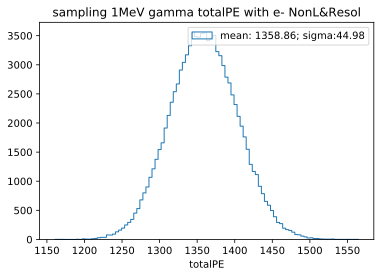

In [373]:
totalPE_1MeV_gamma = np.array(totalPE_1MeV_gamma)
plt.hist(totalPE_1MeV_gamma, histtype='step', bins=100, 
         label="mean: %.2f; sigma:%.2f" %(totalPE_1MeV_gamma.mean(), np.std(totalPE_1MeV_gamma)));
plt.legend()
plt.xlabel('totalPE')
plt.title('sampling 1MeV gamma totalPE with e- NonL&Resol')
#plt.text(1300, 2600, "resolution: %.2f%%" %(np.std(totalPE_1MeV_gamma)/totalPE_1MeV_gamma.mean()*100), fontsize=14, color='green')

In [241]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.03944391795373381

In [247]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.02231931053606704

In [251]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.012814383347594027

In [255]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.009014203674450837

In [190]:
np.std(totalPE_1MeV_gamma) / totalPE_1MeV_gamma.mean()

0.012143506454886564

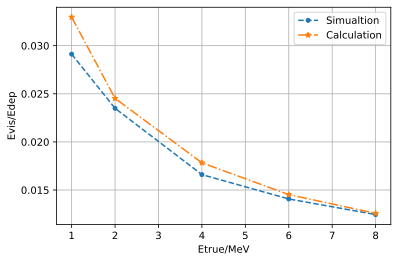

In [357]:
plt.plot([1,2,4,6,8], [0.02912, 0.02349, 0.01660, 0.01407, 0.01245], 'o--', ms=4, label='Simualtion')
#plt.plot([1,2,4,6,8], [0.04362, 0.02748, 0.01822, 0.01420, 0.01214], '*-.', ms=6, label='Calculation')
plt.plot([1,2,4,6,8], calc_resol_gamma, '*-.', ms=6, label='Calculation')

plt.xlabel("Etrue/MeV"); plt.ylabel("Evis/Edep")
plt.grid(True); plt.legend()

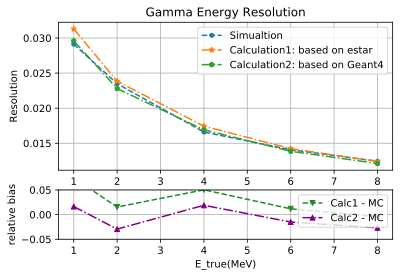

In [461]:

from pylab import *
from matplotlib import gridspec 
gs = gridspec.GridSpec(2,1,height_ratios=[3,1]) 

simul_resol_gamma = [0.02912, 0.02349, 0.01660, 0.01407, 0.01245];

ax0 = plt.subplot(gs[0])
plt.plot([1,2,4,6,8], [0.02912, 0.02349, 0.01660, 0.01407, 0.01245], 'o--', ms=4, label='Simualtion')
plt.plot([1,2,4,6,8], calc_resol_gamma3, '*-.', ms=6, label='Calculation1: based on estar')
plt.plot([1,2,4,6,8], calc_resol_gamma2, 'p-.', ms=5, label='Calculation2: based on Geant4')
#plt.plot([1,2,4,6,8], calc_resol_gamma2, 'p-.', ms=5, label='Calculation2: based on Geant4')


ax0.legend()
plt.grid(True)
plt.ylabel('Resolution')
plt.title('Gamma Energy Resolution')

ax1 = plt.subplot(gs[1])
ax1.plot([1,2,4,6,8], (np.array(calc_resol_gamma3)-np.array(simul_resol_gamma))/np.array(simul_resol_gamma), 
         'v--', ms=5,color='forestgreen', label="Calc1 - MC")
ax1.plot([1,2,4,6,8], (np.array(calc_resol_gamma2)-np.array(simul_resol_gamma))/np.array(simul_resol_gamma),
         '^-.', ms=5,color='purple', label="Calc2 - MC")
plt.grid(True)
#plt.yticks(np.arange(0, 1200, step=400))
plt.xlabel('E_true(MeV)')
plt.ylabel('relative bias')
plt.ylim(-0.05, 0.05)
plt.legend(loc='upper right')

#plt.savefig('compare_totalPE_electron.svg')